## Experiments - Simple Pendulum

Install the following packages

```
conda install anaconda::scipy
conda install anaconda::numpy
conda install conda-forge::matplotlib
conda install anaconda::jupyter
conda install pytorch torchvision torchaudio cpuonly -c pytorch
conda install conda-forge::pytorch-model-summary
```



Make sure the components are what we want

In [1]:
import platform
print(platform.python_version())

3.12.2


### Simple pendulum ODE

In [2]:
def f(t, X):
    g = -9.81
    l = 2.0
    X_new = np.empty(X.shape)
    X_new[0] = X[1]
    X_new[1] = -g/l*np.sin(X[0])
    return X_new

### ODE Solvers

#### Forward Euler (FE) method

2000 points evaluated
Min step 0.004999999999999005 and max step 0.005000000000000782


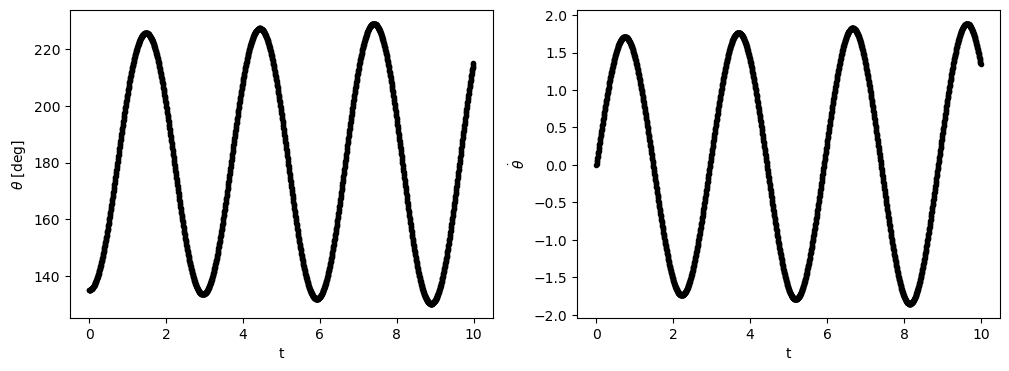

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

Delta_t = 0.005
t_0 = 0.0
t_n = 10.0
t_eval = np.arange(t_0, t_n, Delta_t)
y0 = [np.pi-np.pi/4, 0] # np.pi is pointing downwards and leads to no dynamic behavior, initial angular velocity is zero

# Name similar to ODE solver that returns class with sol.t and sol.y
sol_t = t_eval
sol_y = np.empty((sol_t.shape[0],2))
sol_y[0,:] = y0

for n in range(0,len(sol_t)-1):
    sol_y[n+1,:] = sol_y[n,:]+Delta_t*f(sol_t[n], sol_y[n,:])

print(f'{len(sol_t)} points evaluated')
print(f'Min step {np.min(sol_t[1:]-sol_t[0:-1])} and max step {np.max(sol_t[1:]-sol_t[0:-1])}')
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(sol_t, sol_y[:,0]*180/np.pi)
plt.plot(sol_t, sol_y[:,0]*180/np.pi,'k.')
plt.xlabel('t')
plt.ylabel(r'$\theta$ [deg]')
plt.subplot(122)
plt.plot(sol_t, sol_y[:,1])
plt.plot(sol_t, sol_y[:,1],'k.')
plt.xlabel('t')
plt.ylabel(r'$\dot\theta$')
plt.tight_layout
plt.savefig('ode_pendulum_euler_100pts.png')
plt.show()

#### Adaptive stepsize Runge-Kutta-Fehlberg (RK45) - using error tolerance thresholds

47 points evaluated
Min step 0.011340313177106789 and max step 0.25686236602027934


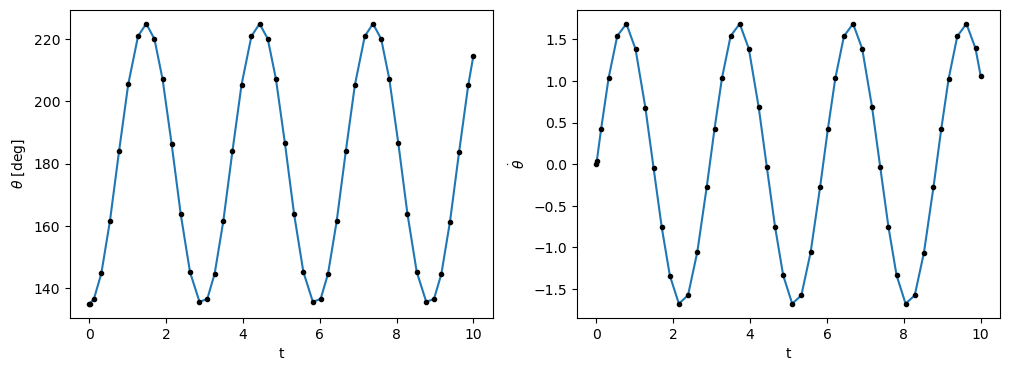

In [48]:
sol = solve_ivp(f, [t_0, t_n], y0, method = 'RK45', rtol=0.000025, atol=0.000001) #t_eval=np.arange(0, 10, 0.01))

print(f'{len(sol.t)} points evaluated')
print(f'Min step {np.min(sol.t[1:]-sol.t[0:-1])} and max step {np.max(sol.t[1:]-sol.t[0:-1])}')
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(sol.t, sol.y[0]*180/np.pi)
plt.plot(sol.t, sol.y[0]*180/np.pi,'k.')
plt.xlabel('t')
plt.ylabel(r'$\theta$ [deg]')
plt.subplot(122)
plt.plot(sol.t, sol.y[1])
plt.plot(sol.t, sol.y[1],'k.')
plt.xlabel('t')
plt.ylabel(r'$\dot\theta$')
plt.tight_layout
plt.savefig('ode_pendulum_rk45.png')
plt.show()

#### Adaptive stepsize Runge-Kutta-Fehlberg (RK45) - user given evaluation points

200 points evaluated
Min step 0.049999999999998934 and max step 0.05000000000000071


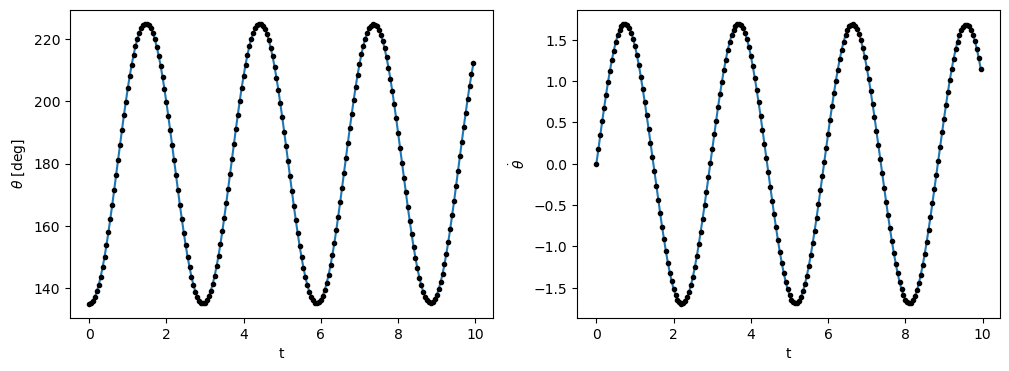

In [49]:
# Instead of tolerance we can also fix the points from which we want ODE45 outputs
Delta_t = 0.05
t_0 = 0.0
t_n = 10.0
t_eval = np.arange(t_0, t_n, Delta_t)

sol = solve_ivp(f, [t_0, t_n], y0, method = 'RK45', t_eval=t_eval)

print(f'{len(sol.t)} points evaluated')
print(f'Min step {np.min(sol.t[1:]-sol.t[0:-1])} and max step {np.max(sol.t[1:]-sol.t[0:-1])}')
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(sol.t, sol.y[0]*180/np.pi)
plt.plot(sol.t, sol.y[0]*180/np.pi,'k.')
plt.xlabel('t')
plt.ylabel(r'$\theta$ [deg]')
plt.subplot(122)
plt.plot(sol.t, sol.y[1])
plt.plot(sol.t, sol.y[1],'k.')
plt.xlabel('t')
plt.ylabel(r'$\dot\theta$')
plt.tight_layout
plt.savefig('ode_pendulum_rk45.png')
plt.show()

### Training data generation

**Trajectory** Generate trajectory of variable length $t_n$ between 5 and 6. This corresponds to real data where recorded trajectories can have different number of samples, and we must deal with them.

210 points evaluated
Min step 0.049999999999998934 and max step 0.05000000000000071


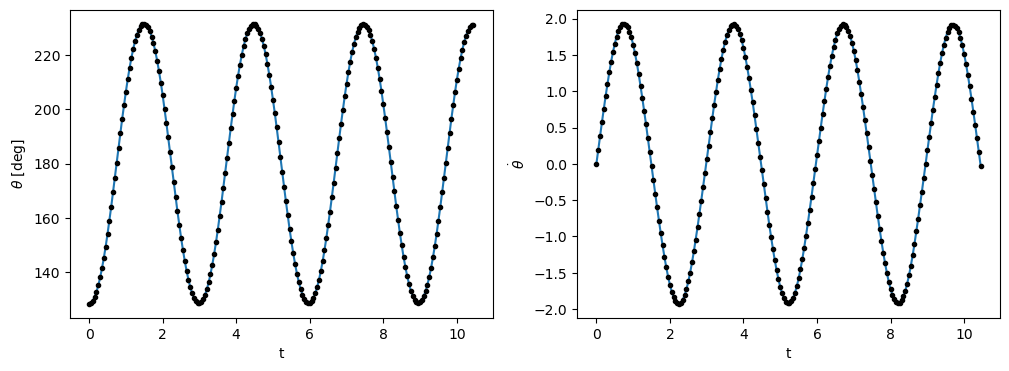

In [51]:
def gen_trajectory(t_0_, t_n_, Delta_t_):

    # starting point is random (point downwards, though) and velocity zero
    y0 = [np.random.uniform(np.pi-np.pi/2, np.pi+np.pi/2), 0]

    t_eval = np.arange(t_0_, t_n_, Delta_t_)

    sol = solve_ivp(f, [t_0_, t_n_], y0, method = 'RK45', t_eval=t_eval)
    return sol

sol = gen_trajectory(0,np.random.uniform(10,15), 0.05)
print(f'{len(sol.t)} points evaluated')
print(f'Min step {np.min(sol.t[1:]-sol.t[0:-1])} and max step {np.max(sol.t[1:]-sol.t[0:-1])}')
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(sol.t, sol.y[0]*180/np.pi)
plt.plot(sol.t, sol.y[0]*180/np.pi,'k.')
plt.xlabel('t')
plt.ylabel(r'$\theta$ [deg]')
plt.subplot(122)
plt.plot(sol.t, sol.y[1])
plt.plot(sol.t, sol.y[1],'k.')
plt.xlabel('t')
plt.ylabel(r'$\dot\theta$')
plt.tight_layout
plt.show()

#### Random sample $N_{tr}$ training and $N_{te}$ test samples

Each tracectory is time duration between 10 and 15 

In [52]:
N_tr = 13
N_te = 11

Y_tr = []
T_tr = []
Y_te = []
T_te = []

tot_samples_tr = 0
for t in range(N_tr):
    sol = gen_trajectory(0,np.random.uniform(10,15), 0.05)
    tot_samples_tr += sol.y.shape[1]
    Y_tr.append(sol.y)
    T_tr.append(sol.t)

tot_samples_te = 0
for t in range(N_te):
    sol = gen_trajectory(0,np.random.uniform(10,15), 0.05)
    tot_samples_te += sol.y.shape[1]
    Y_te.append(sol.y)
    T_te.append(sol.t)

print(f'Generated the total of {tot_samples_tr} training and {tot_samples_te} test samples')

Generated the total of 3303 training and 2836 test samples


### Neural ODE models

The training parameters of each model is adjusted to

 * First find a network structure (number of neurons) and a number of epochs so that the network learns well training data (overfit is OK)
 * Adjust the parameters and scheduler so that the results with the test (now actually validation) data get as good as possible
 * Repeat the experiment five times and record average MSE for the test data - this can be used to compare the methods


#### Baseline 1: MLP

The first baseline directly estimates the state function given the initial point and time step as inputs
$$
y_t = \vartheta_{MLP} (t,y_0)
$$

#### Basic structure for all MLP derivatives

In [53]:
import torch

class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim):
        super().__init__()

        self.dense1 = torch.nn.Linear(input_dim, hidden_size)
        self.dense2 = torch.nn.Linear(hidden_size, hidden_size)
        self.output = torch.nn.Linear(hidden_size, output_dim)

    def forward(self, x):

        x = self.dense1(x)
        x = torch.nn.functional.sigmoid(x)
        x = self.dense2(x)
        x = torch.nn.functional.sigmoid(x)
        y_pred = self.output(x)

        return y_pred

Initialize a model for baseline MLP

In [58]:
# Input [t,theta_0, dottheta_0] Output: [theta, dottheta]
baseline_mlp = MLP(3,16,2)

print(baseline_mlp)

MLP(
  (dense1): Linear(in_features=3, out_features=16, bias=True)
  (dense2): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=2, bias=True)
)


Train the network - outer loop for epochs and inner loop for training trajectories

In [59]:
import torch.optim.lr_scheduler as lr_scheduler

num_of_epochs = 8000
loss_mse = torch.nn.MSELoss()
optimizer_mlp = torch.optim.Adam(baseline_mlp.parameters(), lr=0.1)
scheduler = lr_scheduler.LinearLR(optimizer_mlp, start_factor=0.1, end_factor=0.000001, total_iters=num_of_epochs-10)
baseline_mlp.train()
for n in range(num_of_epochs):
    running_loss = 0.0
    for y,t in zip(Y_tr,T_tr):
        y = torch.from_numpy(y).float().t() # shape N,2
        t = torch.from_numpy(t).float()
        t = t.view(len(t),1) # shape N,1       
        
        y0 = y[0,:]
        y0_vec = y0.repeat(t.shape[0],1)
        X = torch.cat((t,y0_vec),1)
        optimizer_mlp.zero_grad()
        y_pred = baseline_mlp(X)
        loss = loss_mse(y_pred,y)
        loss.backward()
        optimizer_mlp.step()
        running_loss += loss.item()
    scheduler.step()
    if n % 100 == 0:
        print(f'   Epoch {n} training loss {running_loss} (lr={optimizer_mlp.param_groups[0]["lr"]})')

   Epoch 0 training loss 38.55815142393112 (lr=0.009998748448060077)
   Epoch 100 training loss 11.50355039909482 (lr=0.009873593254067572)
   Epoch 200 training loss 8.966463007032871 (lr=0.009748438060075068)
   Epoch 300 training loss 8.317892633378506 (lr=0.009623282866082564)
   Epoch 400 training loss 7.799269853159785 (lr=0.00949812767209006)
   Epoch 500 training loss 7.621408133767545 (lr=0.009372972478097555)
   Epoch 600 training loss 7.485077290330082 (lr=0.00924781728410505)
   Epoch 700 training loss 7.4033388532698154 (lr=0.009122662090112546)
   Epoch 800 training loss 7.3334462102502584 (lr=0.008997506896120042)
   Epoch 900 training loss 7.280138825066388 (lr=0.008872351702127537)
   Epoch 1000 training loss 7.203945923596621 (lr=0.008747196508135033)
   Epoch 1100 training loss 7.057193856686354 (lr=0.008622041314142528)
   Epoch 1200 training loss 7.001046780496836 (lr=0.008496886120150024)
   Epoch 1300 training loss 6.947521721944213 (lr=0.00837173092615752)
   Ep

**Training accuracy** A random train trajectory is always shown as well

Average MSE over 13 trajectories is 1.11671781539917 degrees
Average MAE over 13 trajectories is 12.34084415435791 degrees
Training trajectory and prediction number 3


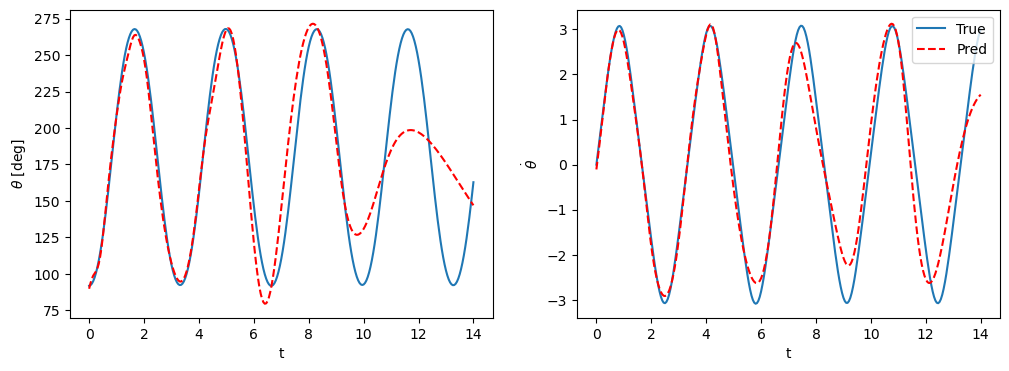

In [61]:
baseline_mlp.eval()
print_ind = np.random.randint(0,N_tr)

ind = -1
theta_mse = []
theta_mae = []
for y,t in zip(Y_tr,T_tr):
    ind += 1
    y = torch.from_numpy(y).float().t() # shape N,2
    t = torch.from_numpy(t).float()
    t = t.view(len(t),1) # shape Nhttps://pytorch.org/docs/stable/generated/torch.t.html#torch.t,1       
        
    y0 = y[0,:]
    y0_vec = y0.repeat(t.shape[0],1)
    X = torch.cat((t,y0_vec),1)

    y_pred = baseline_mlp(X).detach()
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(y[:,0]-y_pred[:,0],2)))/y.shape[0])
    theta_mae.append(torch.sum(abs(y[:,0]-y_pred[:,0]))/y.shape[0])
    
    if ind == print_ind:
        y_plot = y
        y_pred_plot = y_pred
        t_plot = t 
avg_theta_mse = sum(theta_mse)/N_tr
avg_theta_mae = sum(theta_mae)/N_tr
print(f'Average MSE over {N_tr} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_tr} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Training trajectory and prediction number {print_ind}')
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(t_plot, y_plot[:,0]*180/np.pi)
plt.plot(t_plot, y_pred_plot[:,0]*180/np.pi,'r--')
plt.xlabel('t')
plt.ylabel(r'$\theta$ [deg]')
plt.subplot(122)
plt.plot(t_plot, y_plot[:,1])
plt.plot(t_plot, y_pred_plot[:,1],'r--')
plt.xlabel('t')
plt.ylabel(r'$\dot\theta$')
plt.legend(['True', 'Pred'])
plt.tight_layout
plt.show()

**Validation/test accuracy** The first run is validation run, but then the whole script is re-run 5 times for random training and test data to get final comparison results.

Average MSE over 11 trajectories is 0.31622907519340515 degrees
Average MAE over 11 trajectories is 2.564004898071289 degrees
Test trajectory and prediction number 7


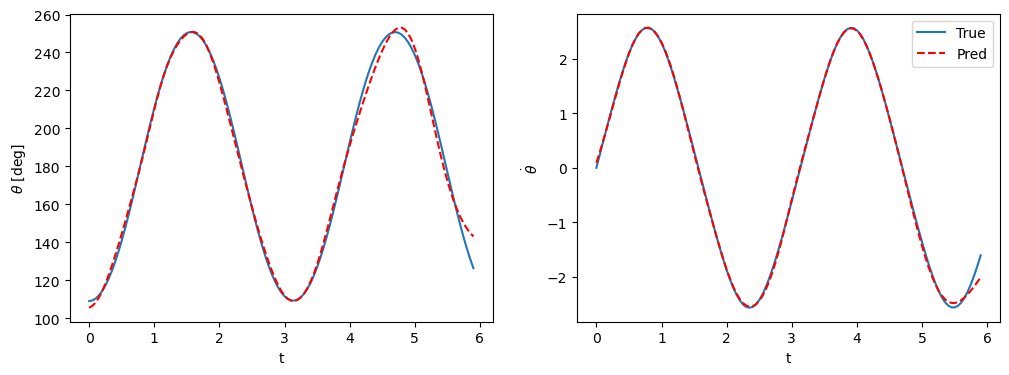

In [24]:
baseline_mlp.eval()
print_ind = np.random.randint(0,N_te)

ind = -1
theta_mse = []
theta_mae = []
for y,t in zip(Y_te,T_te):
    ind += 1
    y = torch.from_numpy(y).float().t() # shape N,2
    t = torch.from_numpy(t).float()
    t = t.view(len(t),1) # shape N,1       
        
    y0 = y[0,:]
    y0_vec = y0.repeat(t.shape[0],1)
    X = torch.cat((t,y0_vec),1)

    y_pred = baseline_mlp(X).detach()
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(y[:,0]-y_pred[:,0],2)))/y.shape[0])
    theta_mae.append(torch.sum(abs(y[:,0]-y_pred[:,0]))/y.shape[0])
    
    if ind == print_ind:
        y_plot = y
        y_pred_plot = y_pred
        t_plot = t 
avg_theta_mse = sum(theta_mse)/N_te
avg_theta_mae = sum(theta_mae)/N_te
print(f'Average MSE over {N_te} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_te} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Test trajectory and prediction number {print_ind}')
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(t_plot, y_plot[:,0]*180/np.pi)
plt.plot(t_plot, y_pred_plot[:,0]*180/np.pi,'r--')
plt.xlabel('t')
plt.ylabel(r'$\theta$ [deg]')
plt.subplot(122)
plt.plot(t_plot, y_plot[:,1])
plt.plot(t_plot, y_pred_plot[:,1],'r--')
plt.xlabel('t')
plt.ylabel(r'$\dot\theta$')
plt.legend(['True', 'Pred'])
plt.tight_layout
plt.show()

#### Findings

The training MSE 0.04 seems good - thist leads to MAE in degrees 1.8deg for training and 2.5deg for validation data.

### Baseline 2: Sequential MLP

The next baseline is the same MLP, but now trained to predict the next state given the current one.
$$
y_{t+1} = \vartheta_{MLPSeq} (y_t)
$$

In [28]:
# Input [theta_n, dottheta_n] Output: [theta_n+1, dottheta_n+1]
baseline_mlpseq = MLP(2,16,2)

print(baseline_mlpseq)

MLP(
  (dense1): Linear(in_features=2, out_features=16, bias=True)
  (dense2): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=2, bias=True)
)


In [29]:
num_of_epochs = 5000
loss_mseseq = torch.nn.MSELoss()
optimizer_mlpseq = torch.optim.Adam(baseline_mlpseq.parameters(), lr=0.1)
scheduler = lr_scheduler.LinearLR(optimizer_mlpseq, start_factor=0.1, end_factor=0.000001, total_iters=num_of_epochs-10)
baseline_mlpseq.train()
for n in range(num_of_epochs):
    running_loss = 0.0
    for y,t in zip(Y_tr,T_tr):
        y = torch.from_numpy(y).float().t() # shape N,2
        t = torch.from_numpy(t).float()
        t = t.view(len(t),1) # shape N,1       

        y_in = y[:-1,:]
        y_out = y[1:,:]
        optimizer_mlpseq.zero_grad()
        y_pred = baseline_mlpseq(y_in)
        loss = loss_mseseq(y_out,y_pred)
        loss.backward()
        optimizer_mlpseq.step()
        running_loss += loss.item()
    scheduler.step()
    if n % 100 == 0:
        print(f'   Epoch {n} training loss {running_loss} (lr={optimizer_mlpseq.param_groups[0]["lr"]})')

   Epoch 0 training loss 45.499943017959595 (lr=0.00999799601202405)
   Epoch 100 training loss 0.01893227246182505 (lr=0.009797597214428877)
   Epoch 200 training loss 0.005802679857879411 (lr=0.009597198416833718)
   Epoch 300 training loss 0.027384901797631755 (lr=0.009396799619238554)
   Epoch 400 training loss 0.004856315514189191 (lr=0.009196400821643391)
   Epoch 500 training loss 0.0034088585452991538 (lr=0.008996002024048232)
   Epoch 600 training loss 0.0030563688051188365 (lr=0.008795603226453064)
   Epoch 700 training loss 0.0043168854535906576 (lr=0.0085952044288579)
   Epoch 800 training loss 0.005369482925743796 (lr=0.008394805631262738)
   Epoch 900 training loss 0.008023355112527497 (lr=0.008194406833667579)
   Epoch 1000 training loss 0.003338811312346479 (lr=0.00799400803607242)
   Epoch 1100 training loss 0.004442479680164979 (lr=0.007793609238477258)
   Epoch 1200 training loss 0.00404399257604382 (lr=0.007593210440882053)
   Epoch 1300 training loss 0.002091546517

**Training accuracy** A random train trajectory is always shown as well

Average MSE over 13 trajectories is 0.14040422439575195 degrees
Average MAE over 13 trajectories is 1.1779664754867554 degrees
Training trajectory and prediction number 6


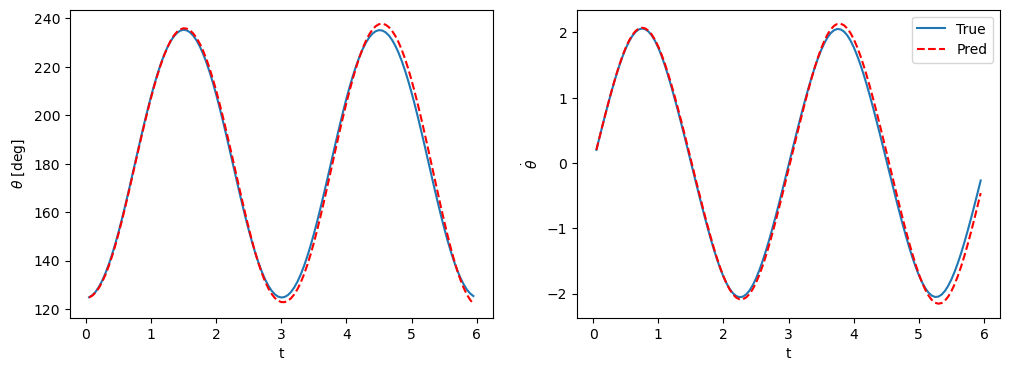

In [33]:
baseline_mlpseq.eval()
print_ind = np.random.randint(0,N_tr)

ind = -1
theta_mse = []
theta_mae = []
for y,t in zip(Y_tr,T_tr):
    ind += 1
    y = torch.from_numpy(y).float().t() # shape N,2
    t = torch.from_numpy(t).float()
    t = t.view(len(t),1) # shape Nhttps://pytorch.org/docs/stable/generated/torch.t.html#torch.t,1       

    y_in = y[:-1,:]
    y_out = y[1:,:]
    t_out = t[1:]
    y_pred = torch.empty(y_out.shape)
    y_pred[0,:] = baseline_mlpseq(y_in[0,:].float())

    for te_ind in range(1,y_out.shape[0]):
        y_pred[te_ind,:] = baseline_mlpseq(y_pred[te_ind-1,:])
    y_pred = y_pred.detach()
    y = y_out # First element is not counted as it is not estimated
    t = t_out
    
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(y[:,0]-y_pred[:,0],2)))/y.shape[0])
    theta_mae.append(torch.sum(abs(y[:,0]-y_pred[:,0]))/y.shape[0])
    
    if ind == print_ind:
        y_plot = y
        y_pred_plot = y_pred
        t_plot = t

avg_theta_mse = sum(theta_mse)/N_tr
avg_theta_mae = sum(theta_mae)/N_tr
print(f'Average MSE over {N_tr} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_tr} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Training trajectory and prediction number {print_ind}')
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(t_plot, y_plot[:,0]*180/np.pi)
plt.plot(t_plot, y_pred_plot[:,0]*180/np.pi,'r--')
plt.xlabel('t')
plt.ylabel(r'$\theta$ [deg]')
plt.subplot(122)
plt.plot(t_plot, y_plot[:,1])
plt.plot(t_plot, y_pred_plot[:,1],'r--')
plt.xlabel('t')
plt.ylabel(r'$\dot\theta$')
plt.legend(['True', 'Pred'])
plt.tight_layout
plt.show()

**Validation/test accuracy** The first run is validation run, but then the whole script is re-run 5 times for random training and test data to get final comparison results.

Average MSE over 11 trajectories is 0.21178822219371796 degrees
Average MAE over 11 trajectories is 1.7354594469070435 degrees
Training trajectory and prediction number 3


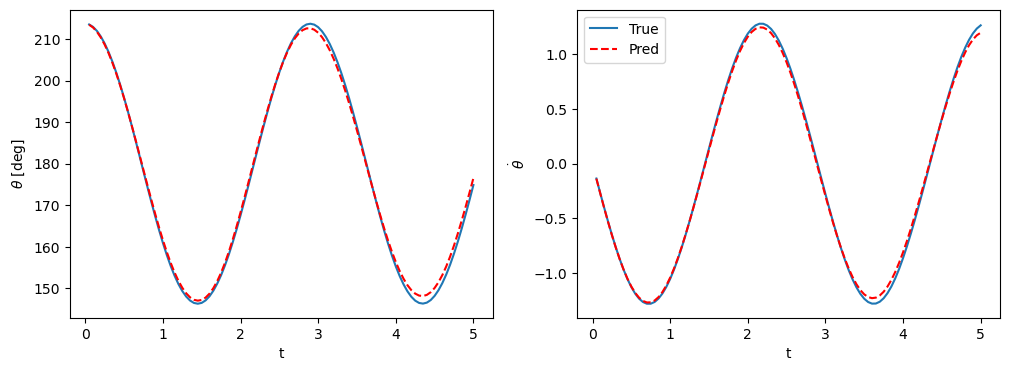

In [35]:
baseline_mlpseq.eval()
print_ind = np.random.randint(0,N_tr)

ind = -1
theta_mse = []
theta_mae = []
for y,t in zip(Y_te,T_te):
    ind += 1
    y = torch.from_numpy(y).float().t() # shape N,2
    t = torch.from_numpy(t).float()
    t = t.view(len(t),1) # shape Nhttps://pytorch.org/docs/stable/generated/torch.t.html#torch.t,1       

    y_in = y[:-1,:]
    y_out = y[1:,:]
    t_out = t[1:]
    y_pred = torch.empty(y_out.shape)
    y_pred[0,:] = baseline_mlpseq(y_in[0,:].float())

    for te_ind in range(1,y_out.shape[0]):
        y_pred[te_ind,:] = baseline_mlpseq(y_pred[te_ind-1,:])
    y_pred = y_pred.detach()
    y = y_out # First element is not counted as it is not estimated
    t = t_out
    
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(y[:,0]-y_pred[:,0],2)))/y.shape[0])
    theta_mae.append(torch.sum(abs(y[:,0]-y_pred[:,0]))/y.shape[0])
    
    if ind == print_ind:
        y_plot = y
        y_pred_plot = y_pred
        t_plot = t

avg_theta_mse = sum(theta_mse)/N_te
avg_theta_mae = sum(theta_mae)/N_te
print(f'Average MSE over {N_te} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_te} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Training trajectory and prediction number {print_ind}')
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(t_plot, y_plot[:,0]*180/np.pi)
plt.plot(t_plot, y_pred_plot[:,0]*180/np.pi,'r--')
plt.xlabel('t')
plt.ylabel(r'$\theta$ [deg]')
plt.subplot(122)
plt.plot(t_plot, y_plot[:,1])
plt.plot(t_plot, y_pred_plot[:,1],'r--')
plt.xlabel('t')
plt.ylabel(r'$\dot\theta$')
plt.legend(['True', 'Pred'])
plt.tight_layout
plt.show()

#### Findings

It looks like the MLPSeq baseline (Baseline 2) works well with the same setting as the previous MLP (Baseline 1). At the end the training MSE error is 0.000026 which is much lower than BL1, but the average training (1.17deg) and validation MAE (1.7deg) are only littler better. 

### Physics-informed Neural Network (PINN)

The next baseline is the same as the MLP of Baseline 1
$$
y_{t} = \vartheta_{PINN} (t,y_0)
$$
but differs in how it is trained. PINN-specific loss function is added to the training loop.

In [37]:
pinn_mlp = MLP(3,16,2)

print(pinn_mlp)

MLP(
  (dense1): Linear(in_features=3, out_features=16, bias=True)
  (dense2): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=2, bias=True)
)


Train by adding the PINNs loss term

In [38]:
num_of_epochs = 5000
pinn_g = -9.81
pinn_l = 2.0
loss_mse_weight = 0.9
loss_mse = torch.nn.MSELoss()
loss_pinn = torch.nn.MSELoss()
optimizer_pinn = torch.optim.Adam(pinn_mlp.parameters(), lr=0.1)
scheduler = lr_scheduler.LinearLR(optimizer_pinn, start_factor=0.1, end_factor=0.000001, total_iters=num_of_epochs-10)
pinn_mlp.train()
for n in range(num_of_epochs):
    running_loss = 0.0
    running_loss_mse = 0.0
    for y,t in zip(Y_tr,T_tr):
        y = torch.from_numpy(y).float().t() # shape N,2
        t = torch.from_numpy(t).float()
        t = t.view(len(t),1) # shape N,1       
        ddot_theta = -pinn_g/pinn_l*torch.sin(y[:,0])
        
        y0 = y[0,:]
        y0_vec = y0.repeat(t.shape[0],1)
        X = torch.cat((t,y0_vec),1)
        optimizer_pinn.zero_grad()
        y_pred = pinn_mlp(X)
        loss_1 = loss_mse(y_pred,y)
        loss_2 = loss_pinn(-pinn_g/pinn_l*torch.sin(y_pred[:,0]),ddot_theta)
        loss = loss_mse_weight*loss_1+(1-loss_mse_weight)*loss_2
        loss.backward()
        optimizer_pinn.step()
        running_loss += loss.item()
        running_loss_mse += loss_1.item()
    scheduler.step()
    if n % 100 == 0:
        print(f'   Epoch {n} training loss {running_loss} [MSE loss {running_loss_mse}] (lr={optimizer_pinn.param_groups[0]["lr"]})')

   Epoch 0 training loss 69.76960444450378 [MSE loss 50.937272787094116] (lr=0.00999799601202405)
   Epoch 100 training loss 17.77166624367237 [MSE loss 10.680339372716844] (lr=0.009797597214428877)
   Epoch 200 training loss 5.201141580939293 [MSE loss 3.4440263211727142] (lr=0.009597198416833718)
   Epoch 300 training loss 3.9316908717155457 [MSE loss 2.843082543462515] (lr=0.009396799619238554)
   Epoch 400 training loss 2.401288429275155 [MSE loss 2.130739141255617] (lr=0.009196400821643391)
   Epoch 500 training loss 1.9441776387393475 [MSE loss 1.7333059441298246] (lr=0.008996002024048232)
   Epoch 600 training loss 1.2959502972662449 [MSE loss 1.2295904718339443] (lr=0.008795603226453064)
   Epoch 700 training loss 1.0133198723196983 [MSE loss 0.8988685682415962] (lr=0.0085952044288579)
   Epoch 800 training loss 0.5614262111485004 [MSE loss 0.5094192661345005] (lr=0.008394805631262738)
   Epoch 900 training loss 0.4486240930855274 [MSE loss 0.393154070712626] (lr=0.008194406833

**Training accuracy** A random train trajectory is always shown as well

Average MSE over 13 trajectories is 0.08961378782987595 degrees
Average MAE over 13 trajectories is 0.7367832660675049 degrees
Training trajectory and prediction number 3


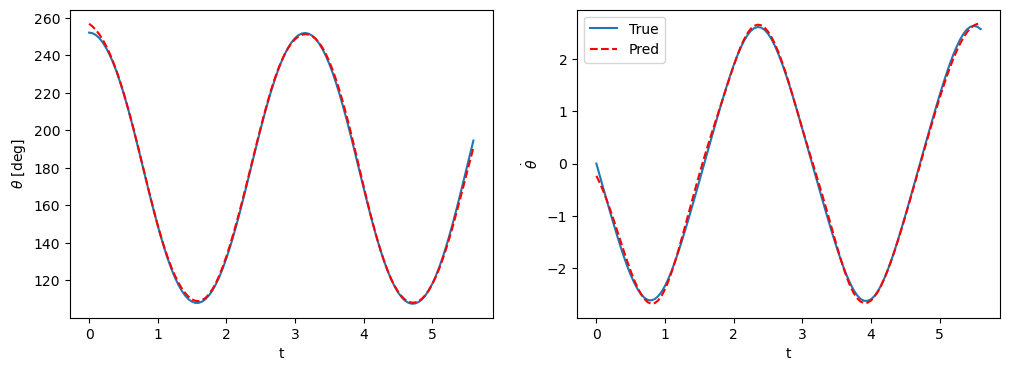

In [42]:
pinn_mlp.eval()
print_ind = np.random.randint(0,N_tr)

ind = -1
theta_mse = []
theta_mae = []
for y,t in zip(Y_tr,T_tr):
    ind += 1
    y = torch.from_numpy(y).float().t() # shape N,2
    t = torch.from_numpy(t).float()
    t = t.view(len(t),1) # shape Nhttps://pytorch.org/docs/stable/generated/torch.t.html#torch.t,1       
        
    y0 = y[0,:]
    y0_vec = y0.repeat(t.shape[0],1)
    X = torch.cat((t,y0_vec),1)

    y_pred = pinn_mlp(X).detach()
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(y[:,0]-y_pred[:,0],2)))/y.shape[0])
    theta_mae.append(torch.sum(abs(y[:,0]-y_pred[:,0]))/y.shape[0])
    
    if ind == print_ind:
        y_plot = y
        y_pred_plot = y_pred
        t_plot = t 
avg_theta_mse = sum(theta_mse)/N_tr
avg_theta_mae = sum(theta_mae)/N_tr
print(f'Average MSE over {N_tr} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_tr} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Training trajectory and prediction number {print_ind}')
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(t_plot, y_plot[:,0]*180/np.pi)
plt.plot(t_plot, y_pred_plot[:,0]*180/np.pi,'r--')
plt.xlabel('t')
plt.ylabel(r'$\theta$ [deg]')
plt.subplot(122)
plt.plot(t_plot, y_plot[:,1])
plt.plot(t_plot, y_pred_plot[:,1],'r--')
plt.xlabel('t')
plt.ylabel(r'$\dot\theta$')
plt.legend(['True', 'Pred'])
plt.tight_layout
plt.show()

**Validation/test accuracy** The first run is validation run, but then the whole script is re-run 5 times for random training and test data to get final comparison results.

Average MSE over 11 trajectories is 0.14979155361652374 degrees
Average MAE over 11 trajectories is 1.2567403316497803 degrees
Test trajectory and prediction number 3


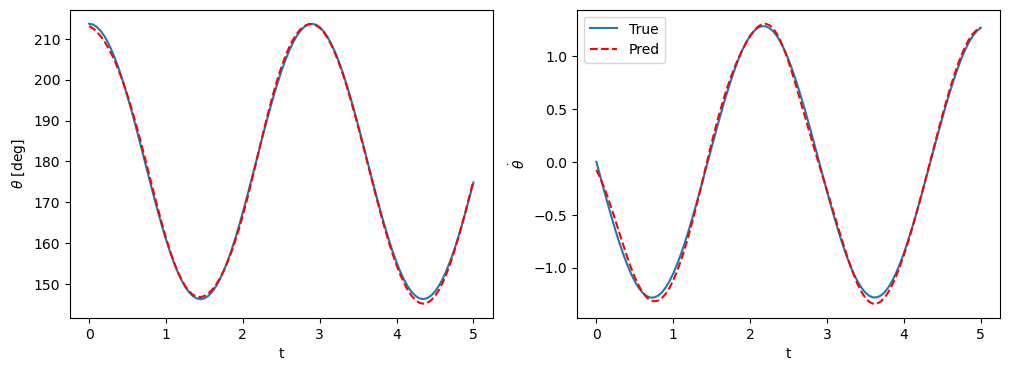

In [46]:
pinn_mlp.eval()
print_ind = np.random.randint(0,N_te)

ind = -1
theta_mse = []
theta_mae = []
for y,t in zip(Y_te,T_te):
    ind += 1
    y = torch.from_numpy(y).float().t() # shape N,2
    t = torch.from_numpy(t).float()
    t = t.view(len(t),1) # shape N,1       
        
    y0 = y[0,:]
    y0_vec = y0.repeat(t.shape[0],1)
    X = torch.cat((t,y0_vec),1)

    y_pred = pinn_mlp(X).detach()
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(y[:,0]-y_pred[:,0],2)))/y.shape[0])
    theta_mae.append(torch.sum(abs(y[:,0]-y_pred[:,0]))/y.shape[0])
    
    if ind == print_ind:
        y_plot = y
        y_pred_plot = y_pred
        t_plot = t 
avg_theta_mse = sum(theta_mse)/N_te
avg_theta_mae = sum(theta_mae)/N_te
print(f'Average MSE over {N_te} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_te} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Test trajectory and prediction number {print_ind}')
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(t_plot, y_plot[:,0]*180/np.pi)
plt.plot(t_plot, y_pred_plot[:,0]*180/np.pi,'r--')
plt.xlabel('t')
plt.ylabel(r'$\theta$ [deg]')
plt.subplot(122)
plt.plot(t_plot, y_plot[:,1])
plt.plot(t_plot, y_pred_plot[:,1],'r--')
plt.xlabel('t')
plt.ylabel(r'$\dot\theta$')
plt.legend(['True', 'Pred'])
plt.tight_layout
plt.show()

#### Findings

MLP with the PINN loss term seems to obtain MSE training error 0.029 and total error 0.031 and average MAE for training data 0.73deg and for validation data 1.25deg

#### LSTM

Construct a simple LSTM

In [54]:
class myLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = torch.nn.LSTM(input_size, hidden_size)
        self.linear = torch.nn.Linear(hidden_size, output_size)


    def forward(self, X, h_t=None, c_t=None):
        if h_t is None:
          outputs, (h_t, c_t) = self.lstm(X)
          outputs = self.linear(outputs)
        else:
          outputs, (h_t, c_t) = self.lstm(X,(h_t,c_t))
          outputs = self.linear(outputs)

        return outputs, h_t, c_t

Use the same loss and optimization as MLP

In [32]:
model_rnn = myLSTM(samples_tr[0].shape[1],8,samples_tr[0].shape[1])

loss_fn_rnn = torch.nn.L1Loss()
#loss_fn_rnn = torch.nn.MSELoss()
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=0.001)

Train LSTM (LSTM needs a scheduler to learn efficiently)

In [33]:
import torch.optim.lr_scheduler as lr_scheduler

num_of_epochs = 1000
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=0.1)
scheduler = lr_scheduler.LinearLR(optimizer_rnn, start_factor=0.1, end_factor=0.0001, total_iters=num_of_epochs-100)
model_rnn.train()
for n in range(num_of_epochs):
    running_loss = 0.0
    for s in samples_tr:
        X = torch.from_numpy(s[:-1]).float()
        Y = torch.from_numpy(s[1:]).float()
        optimizer_rnn.zero_grad()
        Y_pred, _, _ = model_rnn(X)
        loss = loss_fn_rnn(Y_pred,Y)
        loss.backward()
        optimizer_rnn.step()
        running_loss += loss.item()
    scheduler.step()
    if n % 100 == 0:
        print(f'   Epoch {n} training loss {running_loss} (lr={optimizer_rnn.param_groups[0]["lr"]})')

   Epoch 0 training loss 8.852680563926697 (lr=0.009988900000000002)
   Epoch 100 training loss 0.1342917219735682 (lr=0.008878900000000002)
   Epoch 200 training loss 0.17555242404341698 (lr=0.007768900000000002)
   Epoch 300 training loss 0.12338752765208483 (lr=0.006658900000000002)
   Epoch 400 training loss 0.1136183044873178 (lr=0.0055489000000000024)
   Epoch 500 training loss 0.05930069042369723 (lr=0.0044389000000000026)
   Epoch 600 training loss 0.05539143458008766 (lr=0.0033289000000000027)
   Epoch 700 training loss 0.053239771630614996 (lr=0.002218900000000003)
   Epoch 800 training loss 0.027595862629823387 (lr=0.001108900000000003)
   Epoch 900 training loss 0.013861012586858124 (lr=9.999999999999547e-06)


**Evaluation** Compare MLP and RNN with newly generated data

In [50]:
y_vec, u_vec, t_max = gen_trajectory_restricted(env,np.random.randint(100,high=201))

X_te = torch.from_numpy(y_vec[:-1])
Y_te = torch.from_numpy(y_vec[1:])
print(X_te.shape)
print(Y_te.shape)

torch.Size([185, 3])
torch.Size([185, 3])


Run LSTM

In [51]:
model_rnn.eval()

Y_hat_rnn = torch.empty(Y_te.shape)
Y_hat_rnn[0,:], h_t, c_t = model_rnn(X_te[0,:].view(1,-1).float())

for te_ind in range(1,Y_te.shape[0]):
    Y_hat_rnn[te_ind,:], h_t, c_t = model_rnn(Y_hat_rnn[te_ind-1,:].view(1,-1), h_t, c_t)
Y_hat_rnn = Y_hat_rnn.detach()

Run MLP

In [52]:
model_mlp.eval()

Y_hat_mlp = torch.empty(Y_te.shape)
Y_hat_mlp[0,:] = model_mlp(X_te[0,:].float())

for te_ind in range(1,Y_te.shape[0]):
    Y_hat_mlp[te_ind,:] = model_mlp(Y_hat_mlp[te_ind-1,:])
Y_hat_mlp = Y_hat_mlp.detach()

Plot the both in the same figures

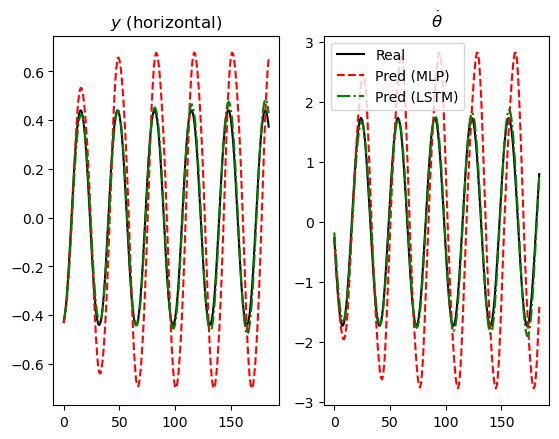

In [53]:
plt.subplot(1,2,1)
plt.title(r'$y$ (horizontal)')
plt.plot(range(Y_te.shape[0]), Y_te[:,1], 'k-', range(Y_te.shape[0]), Y_hat_mlp[:,1], 'r--', range(Y_te.shape[0]), Y_hat_rnn[:,1], 'g-.')
plt.subplot(1,2,2)
plt.plot(range(Y_te.shape[0]), Y_te[:,2], 'k-', range(Y_te.shape[0]), Y_hat_mlp[:,2], 'r--', range(Y_te.shape[0]), Y_hat_rnn[:,2], 'g-.')
plt.title(r'$\dot\theta$')
plt.legend(['Real', 'Pred (MLP)','Pred (LSTM)'])
plt.savefig('pendulum_mlp_vs_rnn_4.png')
plt.show()

Results show that the first 1-2 estimates are close to the starting point, but otherwise estimates are wrong. For example, what happens next is very different for a pendulum swinging from left to right than right to left. And the first action has very little effect to that.